In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [4]:
import lanelines
import roadplane

from swsearch import find_window_centroids

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

## Initialization

In [5]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [6]:
CANVAS_SZ = (500, 1500)
OFFSET_X = 100
OFFSET_Y = 0

straight_images_files = ('test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg')
straight_images = [lanelines.open_image(f) for f in straight_images_files]
straight_images_undist = [cv2.undistort(im, cm, dc) for im in straight_images]

warp_src = roadplane.define_flat_plane_on_road(straight_images_undist, x_offset=0)
warp_src[1, 0] += 8 # <- a hack
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=OFFSET_X, offset_y=OFFSET_Y)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)
Minv = cv2.getPerspectiveTransform(warp_dst, warp_src)

In [7]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [8]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

## Functions

In [9]:
def warp(im, M, canvas_sz):
    return cv2.warpPerspective(im, M, canvas_sz, flags=cv2.INTER_LINEAR)
    

def convert_to_HLS(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HLS)


def weighted_sum_images(images, weights):
    
    assert len(weights) == len(images)
    
    nonzero_indices = np.nonzero(weights)[0]
    if len(nonzero_indices) < 2:
        raise Exception('At least 2 non-zero weights are required')
    
    first, second = nonzero_indices[:2]
    res = cv2.addWeighted(images[first], weights[first], images[second], weights[second], 0)
    
    if len(nonzero_indices) == 2:
        return res
    
    for i in nonzero_indices[2:]:
        res = cv2.addWeighted(res, 1., images[i], weights[i], 0)
        
    return res


def bitwise_or(images):
    
    assert len(images) > 0
    
    if len(images) == 1:
        return images[0]
    
    res = cv2.bitwise_or(images[0], images[1])
    if len(images) == 2:
        return res
    
    for im in images[2:]:
        res = cv2.bitwise_or(res, im)
        
    return res
    
    
def weighted_HLS(H, L, S, weights):
    return weighted_sum_images([H, L, S], weights)


def add_contrast(im, gain):
    gained = gain * im
    return lanelines.scale_image_255(gained)


def sobel_combo(im):
    
    sobelx = lanelines.sobel_x(im)
    sobely = lanelines.sobel_y(im)
    
    magnitude = lanelines.sobel_magnitude(sobelx, sobely)
    direction = lanelines.sobel_direction(sobelx, sobely)
    
    return lanelines.scale_image_255(magnitude), lanelines.scale_image_255(direction)


def scaled_sobel_x(im):
    return lanelines.scale_image_255( lanelines.sobel_x(im) )


def morphological_close(im, kernel=(3, 3)):
    return cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)


def get_hls_channels(im):
    
    hls = convert_to_HLS(im)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    return H, L, S

def gray(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

def gather_thresholded_images(*images):
    return images

def lane_cells(im, nx, ny, threshold=20):
    
    cells = divide_image_to_cells(im, nx, ny)
    
    res = []
    
    for i in range(ny):
        
        idx_from = i * nx
        idx_to = i * nx + nx
        
        rowcells = cells[idx_from:idx_to]
        
        sums = np.array([np.sum(cell) for cell in rowcells])
        max_j = np.argmax(sums)
        
        if sums[max_j] > threshold:
            res.append( (i, max_j) ) 
        
    return np.array(res)


def lane_cells_real_coords(lanecells, im, nx, ny):
    
    rows, cols= im.shape[:2]
    
    cell_sz_x = cols // nx
    cell_sz_y = rows // ny
    
    points = np.zeros_like(lanecells)
    
    for i in range(len(lanecells)):
        idx_row, idx_col = lanecells[i, :]
        x = idx_col * cell_sz_x + cell_sz_x / 2
        y = idx_row * cell_sz_y + cell_sz_y / 2
        points[i, :] = (x, y)
        
    return points
    
        

def divide_image_to_cells(im, nx, ny):
    
    rows, cols= im.shape[:2]
    
    assert rows % ny == 0
    assert cols % nx == 0
    
    offset_x = cols // nx
    offset_y = rows // ny
    
    cells = []
    
    for j in range(ny):
        for i in range(nx):
            
            x_from = i * offset_x
            x_to = x_from + offset_x 
            y_from = j * offset_y
            y_to = y_from + offset_y

            cell = im[y_from:y_to, x_from:x_to]
            
            cells.append(cell)
            
    return cells


def show_cells(cells, nx, ny):
    
    for i, cell in enumerate(cells):
        plt.subplot(ny, nx, i+1)
        plt.axis('off')
        plt.imshow(cell)
            
            
def split_image_lr(im):

    cols = im.shape[1]
    middle = cols // 2
    return im[:, :middle], im[:, middle:]
    

def split_image_lr_and_show(im):

    left, right = split_image_lr(im)
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(left)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(right)
    

def get_polynomial_2(coefs):
    
    a, b, c = coefs
    
    def f(y):
        return a * (y**2) + b * y + c
    
    return f

def fit_lane_polynomials(im, nx=50, ny=100, lanecell_threshold=70):
    
    left, right = split_image_lr(im)
    
    target_cells_left = lane_cells(left, nx, ny, threshold=70)
    target_cells_coords_left = lane_cells_real_coords(target_cells_left, left, nx, ny)
    p_coefs_left = np.polyfit(target_cells_coords_left[:, 1], target_cells_coords_left[:, 0], 2)

    target_cells_right = lane_cells(right, nx, ny, threshold=70)
    target_cells_coords_right = lane_cells_real_coords(target_cells_right, right, nx, ny)
    target_cells_coords_right[:, 0] += left.shape[1]
    p_coefs_right = np.polyfit(target_cells_coords_right[:, 1], target_cells_coords_right[:, 0], 2)
    
    return p_coefs_left, p_coefs_right, target_cells_coords_left, target_cells_coords_right
    


def get_lane_polynomials_points(warped_im, p_coefs_left, p_coefs_right):
    
    poly_left = get_polynomial_2(p_coefs_left)
    poly_right = get_polynomial_2(p_coefs_right)

    poly_y = np.linspace(0, warped_im.shape[0])
    poly_x_left = poly_left(poly_y)
    poly_x_right = poly_right(poly_y)
    
    return poly_y, poly_x_left, poly_x_right


def lanefill(image, warped, Minv, poly_y, poly_x_left, poly_x_right):
    
    canvas = np.zeros_like(warped).astype(np.uint8)
    
    pts_left = np.array([np.transpose(np.vstack([poly_x_left, poly_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([poly_x_right, poly_y])))])
    pts = np.hstack((pts_left, pts_right)).astype(np.int32)

    cv2.fillPoly(canvas, [pts], (0, 255, 0))

    newwarp = cv2.warpPerspective(canvas, Minv, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
    

## Pipeline

In [10]:
func_dict = {
    'warp': warp,
    'gray': gray,
    'get_HLS': get_hls_channels,
    'weighted_HLS_sum': weighted_HLS,
    'threshold_gray': lanelines.mask_threashold_range,
    'threshold_S': lanelines.mask_threashold_range,
    'threshold_H': lanelines.mask_threashold_range,
    'threshold_wHLS': lanelines.mask_threashold_range,
    'apply_sobel_x_to_S': scaled_sobel_x,
    'threshold_S_sobel_x': lanelines.mask_threashold_range,
    'median_blur_tssx': cv2.medianBlur,
    'close_thresholded_S': morphological_close,
    'gather_thresholded_images': gather_thresholded_images,
    'combine_thresholds_bitwise_or': bitwise_or,
    'fit_lane_polynomials': fit_lane_polynomials,
    'get_lane_polynomials_points': get_lane_polynomials_points,
    'lanefill': lanefill,
    
}

func_io = {
    'warp': (('image', 'M', 'canvas_size'), 'warped'),
    'gray': ('warped', 'warped_gray'),
    'get_HLS': ('warped', ('H', 'L', 'S')),
    'weighted_HLS_sum': (('H', 'L', 'S', 'HLS_weights'), 'weighted_HLS'),
    'threshold_gray': (('warped_gray', 'gray_from', 'gray_to'), 'thresholded_gray'),
    'threshold_S': (('S', 'S_from', 'S_to'), 'thresholded_S'),
    'threshold_H': (('H', 'H_from', 'H_to'), 'thresholded_H'),
    'threshold_wHLS': (('weighted_HLS', 'wHLS_from', 'wHLS_to'), 'thresholded_wHLS'),
    'apply_sobel_x_to_S': ('S', 'S_sobel_x'),
    'threshold_S_sobel_x': (('S_sobel_x', 'S_sobel_x_from', 'S_sobel_x_to'), 'thresholded_S_sobel_x'),
    'median_blur_tssx': (('thresholded_S_sobel_x', 'tssx_median_kernel'), 'tssx_median'),
    'close_thresholded_S': (('thresholded_S', 'close_kernel_for_tS'), 'ts_closed'),
    'gather_thresholded_images' : (
        ('thresholded_S', 'thresholded_wHLS', 'thresholded_S_sobel_x', 'tssx_median', 'ts_closed', 'thresholded_gray'),
        'thresholded_images'
    ),
    'combine_thresholds_bitwise_or': ('thresholded_images', 'all_thresholds'),
    'fit_lane_polynomials': (('all_thresholds', 'n_cells_x', 'n_cells_y', 'cell_threshold'), ('p_coefs_left', 'p_coefs_right', 'target_cells_coords_left', 'target_cells_coords_right')),
    'get_lane_polynomials_points': (('warped_gray', 'p_coefs_left', 'p_coefs_right'), ('poly_y', 'poly_x_left', 'poly_x_right')),
    'lanefill': (('image', 'warped', 'Minv', 'poly_y', 'poly_x_left', 'poly_x_right'), 'filled'),
    
}

cg = CompGraph(func_dict, func_io)

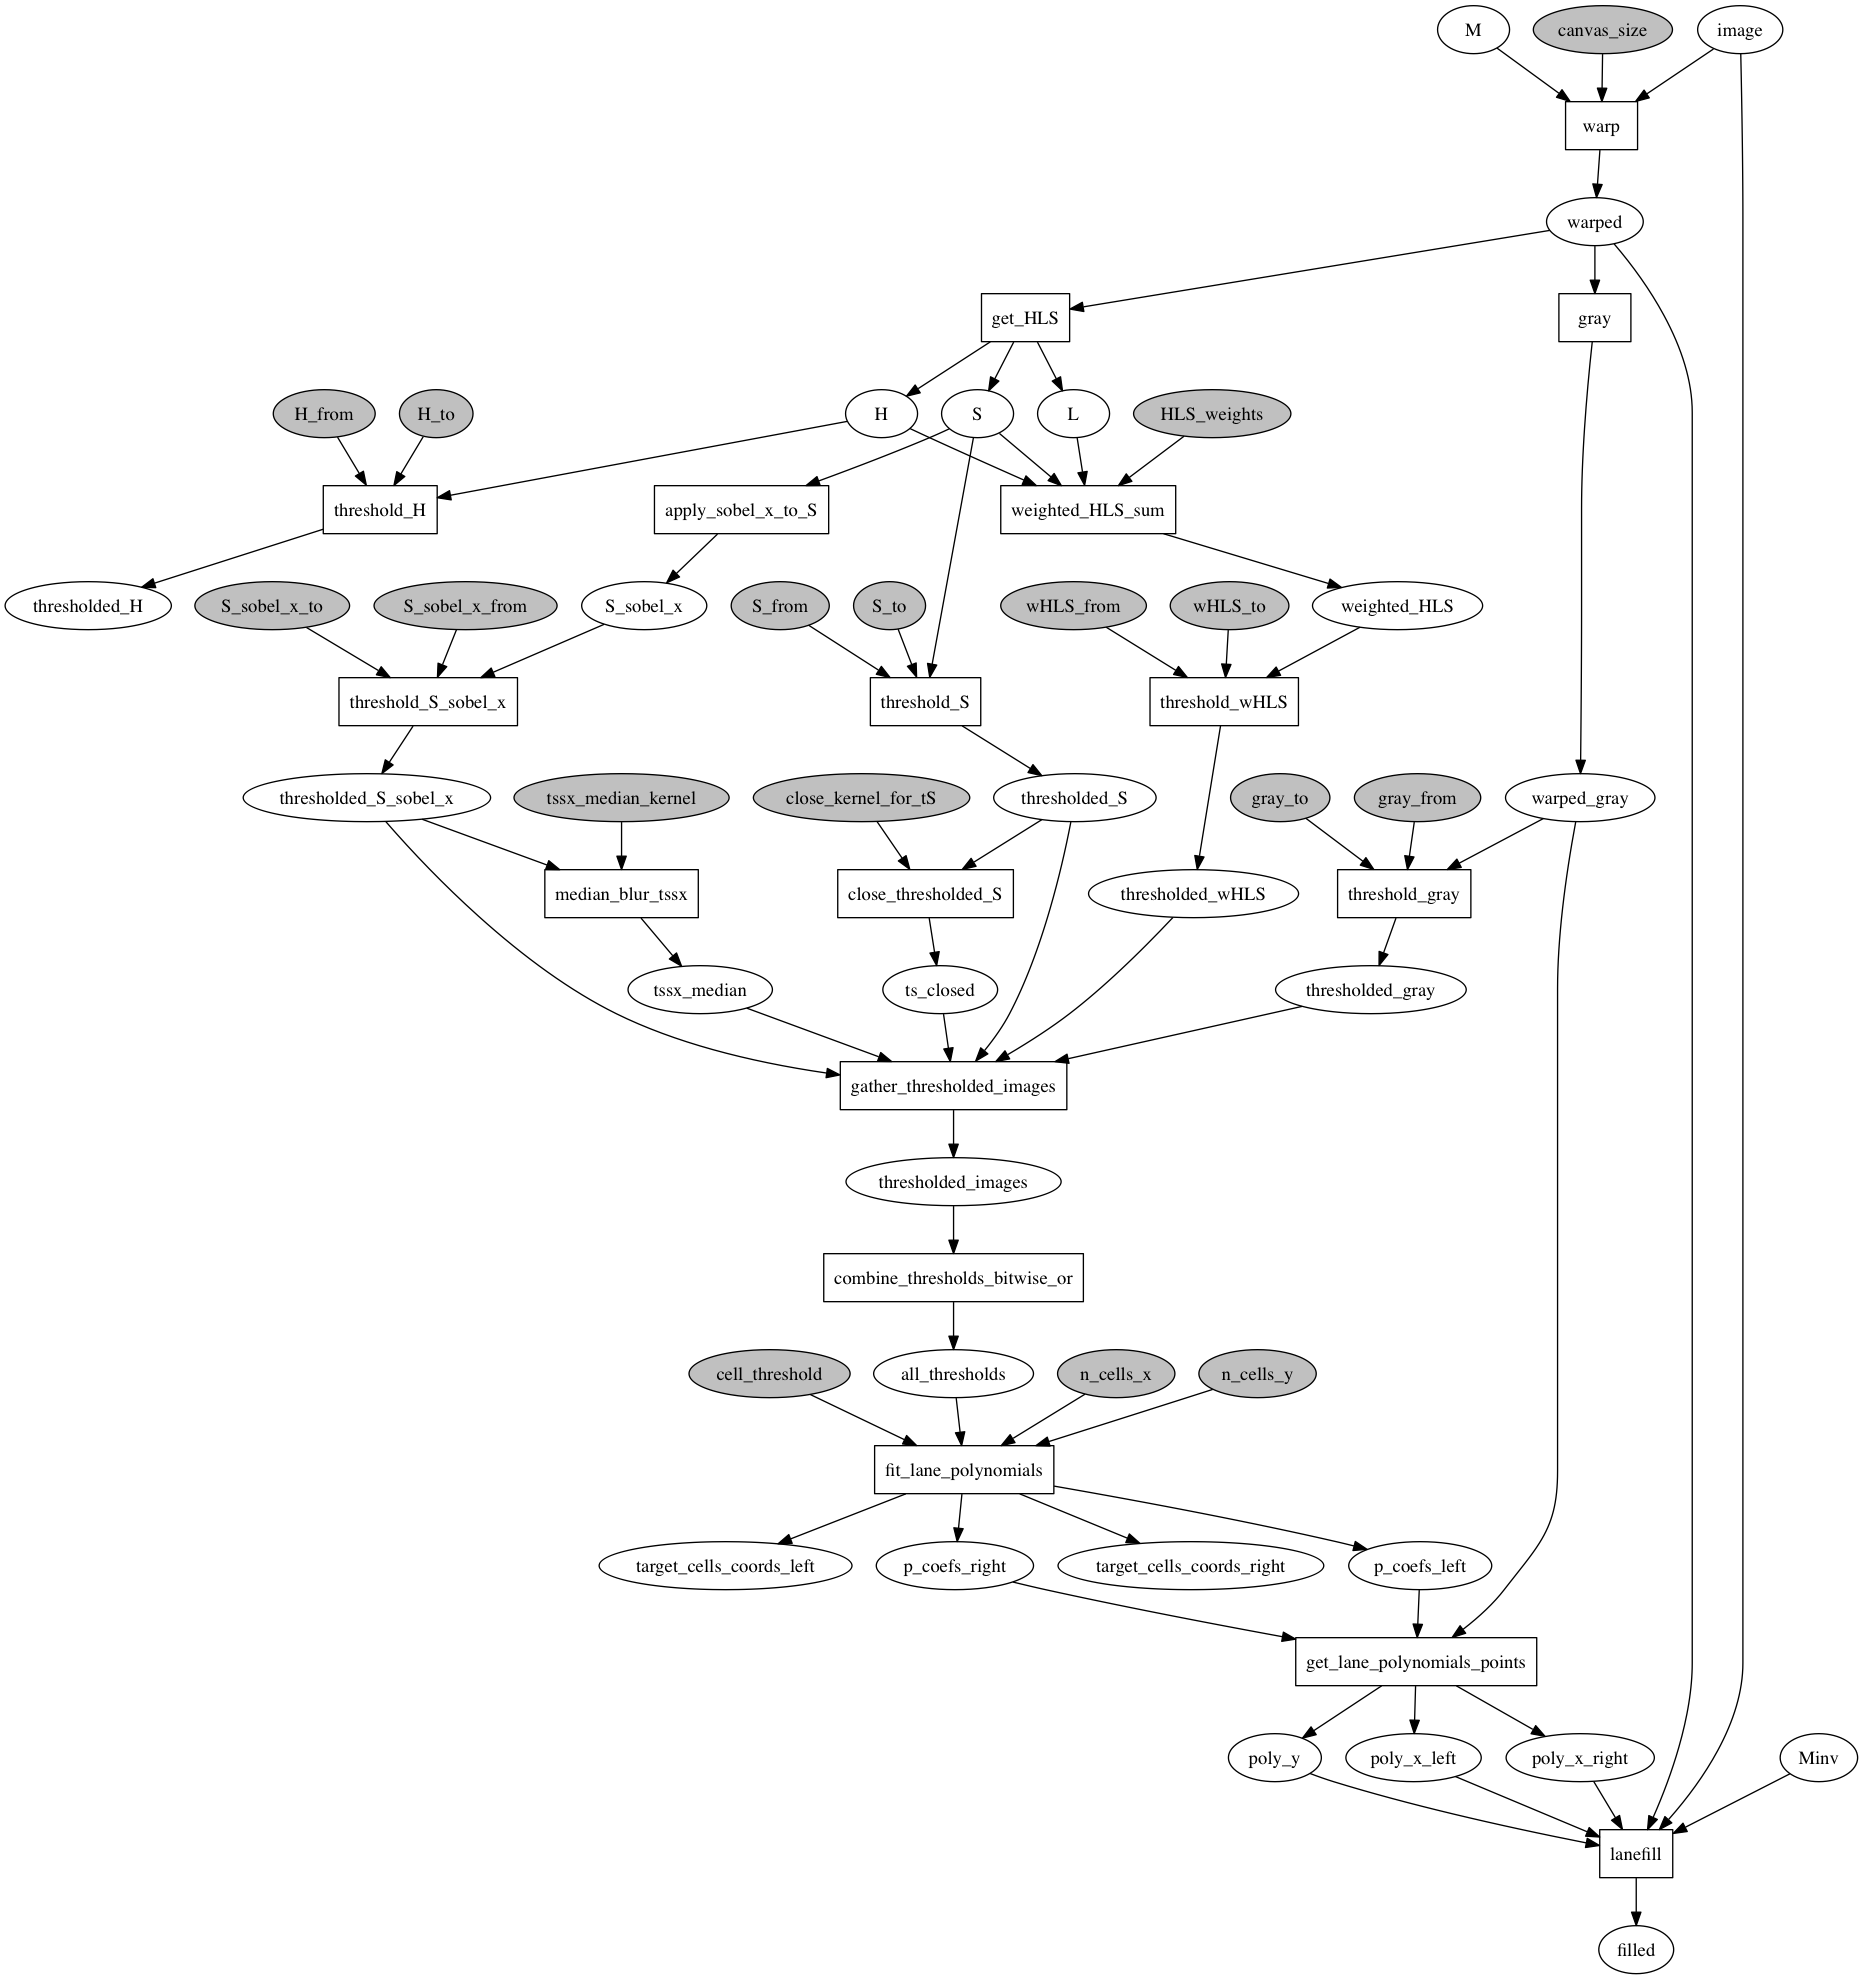

In [11]:
params = {
    'canvas_size': (500, 1500),
    'HLS_weights': [0, 0.4, 1.],   
    'gray_from': 210,
    'gray_to': 255,
    'S_from': 180,
    'S_to': 255,
    'H_from': 95,
    'H_to': 100,
    'wHLS_from': 180,
    'wHLS_to': 255,  
    'S_sobel_x_from': 20, 
    'S_sobel_x_to': 240, 
    'tssx_median_kernel': 5,
    'close_kernel_for_tS': (3, 3),
    'n_cells_x': 50, 
    'n_cells_y': 100, 
    'cell_threshold': 70,
}

runner = CompGraphRunner(cg, frozen_tokens=params)
runner.run(image=test_images_undist[1], M=M, Minv=Minv)

nxpd.draw(runner.token_manager.to_networkx())

## Experiments

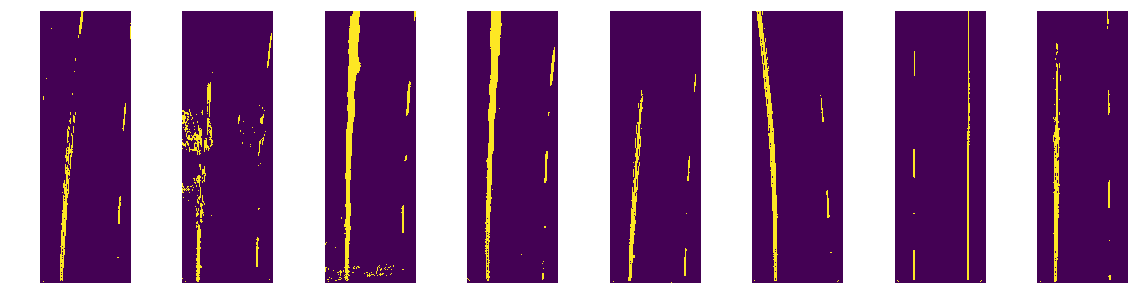

In [12]:
plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')

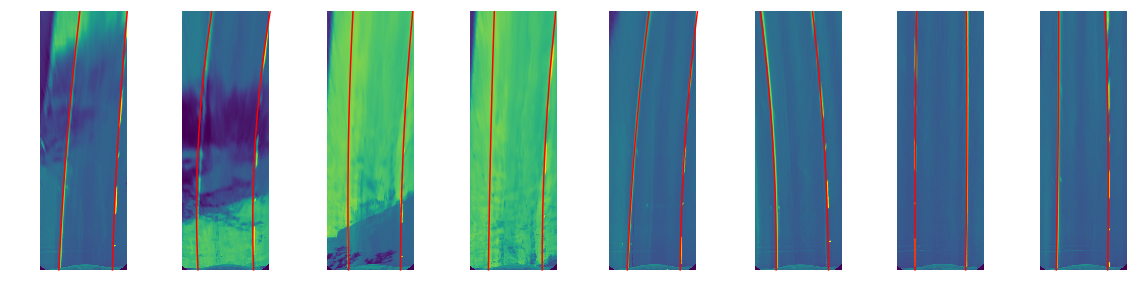

In [13]:
plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    plt.subplot(1, 8, i+1)
    _ = plt.axis('off')
    
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.imshow(runner['warped_gray'])
    
    plt.plot(runner['poly_x_left'], runner['poly_y'], color='r')
    plt.plot(runner['poly_x_right'], runner['poly_y'], color='r')

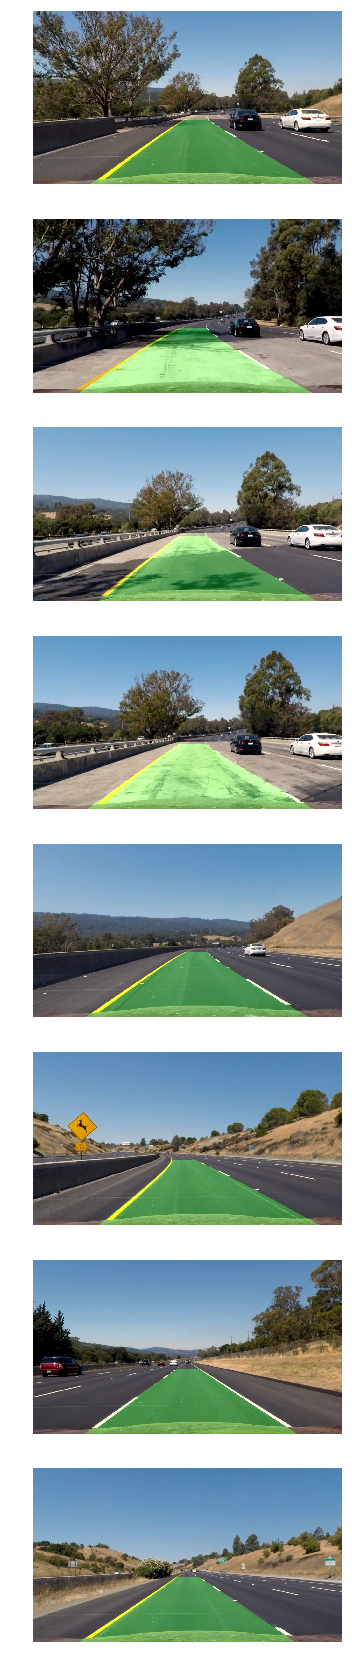

In [14]:
plt.figure(figsize=(8, 30))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(8, 1, i+1)
    plt.imshow( cv2.cvtColor( runner['filled'], cv2.COLOR_BGR2RGB ) )
    _ = plt.axis('off')